# SVD 학습
- numpy svd를 활용해 직접 행렬 분해를 구현해본다
- SVD를 수행하기 위해서는 rating 매트릭스가 모두 채워져 있어야 한다.
    - SVD에 적합하게 dense matrix를 만들어본다
    - user average / item average
- latent factor 개수에 따라서 달라지는 rmse 값을 확인해본다

## 학습 데이터 준비

In [1]:
import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = '../data/ml-latest-small/'

In [3]:
ratings_df = pd.read_csv(path + 'ratings.csv', encoding='utf-8')

In [4]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


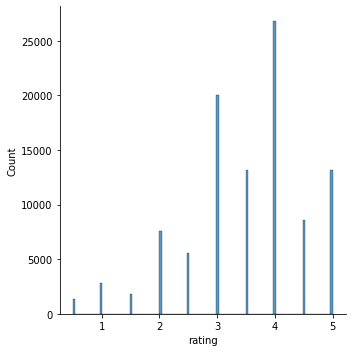

In [5]:
sns.displot(ratings_df['rating'])

## numpy로 직접 SVD 구현하기

In [6]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=10)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


In [7]:
user_item_matrix = train_df.pivot_table('rating', 'userId', 'movieId')

- SVD를 수행하기 위해서는 빈 entry가 없는 dense matrix가 되어야 합니다
- 행렬의 비어있는 entry에 유저 혹은 아이템 기준으로 구한 평균 평점을 채워넣습니다

In [8]:
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193567,193571,193573,193579,193581,193583,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# 유저 평균 평점으로 빈 entry를 채움
user_item_matrix = user_item_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

# 아이템 평균 평점으로 빈 entry를 채움
# user_item_matrix = user_item_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [10]:
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193567,193571,193573,193579,193581,193583,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.000000,4.372973,4.000000,4.372973,4.372973,4.000000,4.372973,4.372973,4.372973,4.372973,...,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973
2,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,...,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333
3,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,...,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517
4,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,...,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989
5,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,...,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.500000,3.665341,3.665341,3.665341,3.665341,3.665341,2.500000,3.665341,3.665341,3.665341,...,3.665341,3.665341,3.665341,3.665341,3.665341,3.665341,3.665341,3.665341,3.665341,3.665341
607,4.000000,3.816901,3.816901,3.816901,3.816901,3.816901,3.816901,3.816901,3.816901,3.816901,...,3.816901,3.816901,3.816901,3.816901,3.816901,3.816901,3.816901,3.816901,3.816901,3.816901
608,2.500000,3.128720,2.000000,3.128720,3.128720,3.128720,3.128720,3.128720,3.128720,3.128720,...,3.128720,3.128720,3.128720,3.128720,3.128720,3.128720,3.128720,3.128720,3.128720,3.128720


- numpy에서 제공하는 [svd](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)

In [17]:
def calculate_SVD(matrix, k = 20):

    # numpy svd 수행
    u, sig, i = np.linalg.svd(matrix)
    
    # 유저 매트릭스 가운데 k개 latent factor만 사용
    # u.shape = (610, 610)
    u_hat = u[:, :k]
    
    # 아이템 매트릭스 가운데 k개 latent factor만 사용
    # i.shape = (9001, 9001) 
    i_hat = i[:k, :]
    
    # 잠재 요인 대각 행렬
    # sig는 matrix의 singular value값이며 가장 큰 값부터 내림차순으로 정렬되어 있음.
    # length(sig) = min(610, 9100) = 610
    sig_hat = sig[:k] * np.identity(k, np.float)
        
    user_factors = u_hat
    item_factors = np.matmul(sig_hat, i_hat)
    
    return user_factors, item_factors

In [18]:
k = 50
user_factors, item_factors = calculate_SVD(user_item_matrix, k)

In [19]:
# 유저 잠재 요인, 아이템 잠재 요인 행렬
print(user_factors.shape)
print(item_factors.shape)

(610, 50)
(50, 9001)


In [20]:
# 두 잠재 요인 행렬을 곱하면 유저-아이템 조합에 대한 예측 평점의 행렬을 구할 수 있습니다.
prediction_result_df = pd.DataFrame(np.matmul(user_factors, item_factors),
                                    columns=user_item_matrix.columns.values, index=user_item_matrix.index.values)

In [21]:
# train 데이터로 만든 평점 예측값 R_hat
prediction_result_df

,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193567,193571,193573,193579,193581,193583,193587,193609
1,4.455760,4.376862,4.445517,4.378512,4.336953,4.230930,4.287235,4.378368,4.379953,4.338540,...,4.374534,4.372675,4.371745,4.373604,4.373604,4.372675,4.373604,4.372675,4.372675,4.373269
2,4.116021,4.093123,4.059365,4.075956,4.089813,4.076023,4.054649,4.081869,4.076706,4.093391,...,4.085951,4.082815,4.081246,4.084383,4.084383,4.082815,4.084383,4.082815,4.082815,4.083071
3,2.489142,2.493289,2.435234,2.471230,2.497086,2.406091,2.466641,2.491103,2.462545,2.481086,...,2.467970,2.465050,2.463590,2.466510,2.466510,2.465050,2.466510,2.465050,2.465050,2.465735
4,3.438885,3.538087,3.404722,3.516883,3.387723,3.323818,3.443567,3.498151,3.554042,3.884841,...,3.524558,3.522719,3.521799,3.523639,3.523639,3.522719,3.523639,3.522719,3.522719,3.526527
5,3.535751,3.476395,3.438381,3.478689,3.454173,3.565401,3.468226,3.491675,3.488108,3.454820,...,3.500828,3.499840,3.499346,3.500334,3.500334,3.499840,3.500334,3.499840,3.499840,3.500740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.080360,3.688198,3.524394,3.673937,3.584164,3.757912,2.530674,3.511241,3.703077,3.715367,...,3.661908,3.665996,3.668041,3.663952,3.663952,3.665996,3.663952,3.665996,3.665996,3.657973
607,3.794047,3.738736,3.911573,3.795850,3.789813,3.785160,3.717314,3.807169,3.807893,3.695064,...,3.819084,3.816495,3.815200,3.817790,3.817790,3.816495,3.817790,3.816495,3.816495,3.816851
608,2.350255,3.199218,1.928100,3.104161,3.148591,3.270782,3.159779,3.074696,3.115715,3.212388,...,3.126966,3.129054,3.130098,3.128010,3.128010,3.129054,3.128010,3.129054,3.129054,3.120215
609,3.311869,3.274965,3.261605,3.256527,3.258811,3.307523,3.266666,3.262454,3.261982,3.301365,...,3.270620,3.268960,3.268130,3.269790,3.269790,3.268960,3.269790,3.268960,3.268960,3.269617


In [22]:
# 예측 평점을 사용해서 test 데이터를 예측해봅니다

# test 데이터에 새로 등장하는 유저, 아이템을 위한 global rating
global_rating = train_df['rating'].mean()

result = []

for _, row in tqdm(test_df.iterrows()):
    
    # 예측해야 하는 유저, 아이템, 평점
    user_id = row['userId']
    movie_id = row['movieId']
    true_rating = row['rating']
    
    if user_id in prediction_result_df.index.values and movie_id in prediction_result_df.columns.values:
        pred_rating = prediction_result_df.loc[user_id][movie_id]
    else:
        pred_rating = global_rating
        
    result.append([user_id, movie_id, true_rating, pred_rating])

result_df = pd.DataFrame(result, columns=['user_id', 'movie_id', 'true_rating', 'pred_rating'])

20168it [00:04, 4340.51it/s]


In [23]:
result_df

,user_id,movie_id,true_rating,pred_rating
0,239.0,924.0,4.0,4.106564
1,384.0,2763.0,3.0,2.957313
2,52.0,58559.0,5.0,4.640744
3,600.0,719.0,2.5,3.038116
4,318.0,117364.0,4.0,3.503954
...,...,...,...,...
20163,20.0,5015.0,4.0,3.472314
20164,177.0,6787.0,3.0,3.400911
20165,103.0,969.0,4.0,3.926839
20166,42.0,2875.0,3.0,3.609600


In [24]:
print("RMSE:", np.sqrt(mean_squared_error(result_df['true_rating'].values, result_df['pred_rating'].values)))

RMSE: 0.9342638634779802


## SVD의 적합한 k 찾기
- SVD를 수행할 때 사용하는 잠재요인의 숫자는 사용자가 정하는 하이퍼파라미터이다
- k에 따라 학습 성능과 예측 성능이 얼마나 달라지는지 실험해보자

In [25]:
# 사용자 평균 평점으로 빈 entry를 채움
user_item_matrix = train_df.pivot_table('rating', 'userId', 'movieId')
user_item_matrix = user_item_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

In [26]:
global_rating = train_df['rating'].mean()

train_result = []
test_result = []

# k에 따라서 모델을 학습하고 평가함
for k in tqdm(np.arange(2, 20, 2)):

    # 모델 학습 및 평점 추론
    user_factors, item_factors = calculate_SVD(user_item_matrix, k)
    prediction_result_df = pd.DataFrame(np.matmul(user_factors, item_factors),
                                    columns=user_item_matrix.columns.values, index=user_item_matrix.index.values)
    
    # 학습 데이터 평가
    pred_rating = []
    true_rating = []
    for _, row in train_df.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        true_rating.append(row['rating'])

        if user_id in prediction_result_df.index.values and movie_id in prediction_result_df.columns.values:
            pred_rating.append(prediction_result_df.loc[user_id][movie_id])
        else:
            pred_rating.append(global_rating)

    rmse = np.sqrt(mean_squared_error(np.asarray(true_rating), np.asarray(pred_rating)))
    train_result.append([k, rmse])
    
    # 테스트 데이터 평가
    pred_rating = []
    true_rating = []
    for _, row in test_df.iterrows():

        user_id = row['userId']
        movie_id = row['movieId']
        true_rating.append(row['rating'])

        if user_id in prediction_result_df.index.values and movie_id in prediction_result_df.columns.values:
            pred_rating.append(prediction_result_df.loc[user_id][movie_id])
        else:
            pred_rating.append(global_rating)
    
    rmse = np.sqrt(mean_squared_error(np.asarray(true_rating), np.asarray(pred_rating)))
    test_result.append([k, rmse])
    
k_train_result_df = pd.DataFrame(train_result, columns=['k', 'rmse'])
k_test_result_df = pd.DataFrame(test_result, columns=['k', 'rmse'])

100%|██████████| 9/9 [05:28<00:00, 36.54s/it]


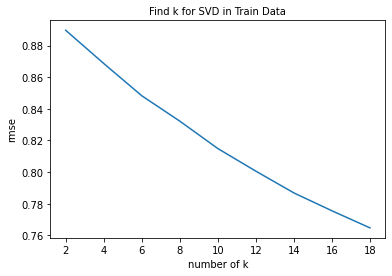

In [27]:
plt.plot(k_train_result_df.k, k_train_result_df.rmse)
plt.title("Find k for SVD in Train Data", fontsize=10)
plt.xlabel('number of k', fontsize=10)
plt.ylabel('rmse', fontsize=10)
plt.show()

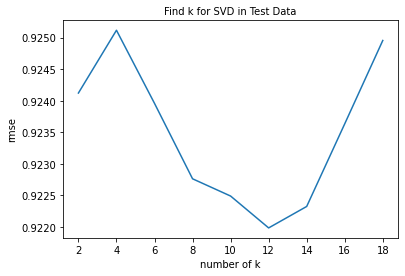

In [28]:
plt.plot(k_test_result_df.k, k_test_result_df.rmse)
plt.title("Find k for SVD in Test Data", fontsize=10)
plt.xlabel('number of k', fontsize=10)
plt.ylabel('rmse', fontsize=10)
plt.show()